In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [4]:
df = pd.read_csv('data/Annual changes in global temperature 18801985.csv')
df.set_index('x').sort_index()

,Unnamed: 0
x,
-0.72,5
-0.54,6
-0.54,8
-0.49,14
-0.49,25
...,...
0.19,59
0.20,74
0.27,101


Предсказание временного ряда с помощью деревьев

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

In [6]:
n_vars = 1 if type(df) is list else df.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [7]:
len(list_for_forecast)

105

In [8]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [9]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [10]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  0.13185055555555572


In [11]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 0.15755377332482046
MAPE: 2.2758096937432506
MAE: 0.13185055555555572
R2:  -0.14421881382842616


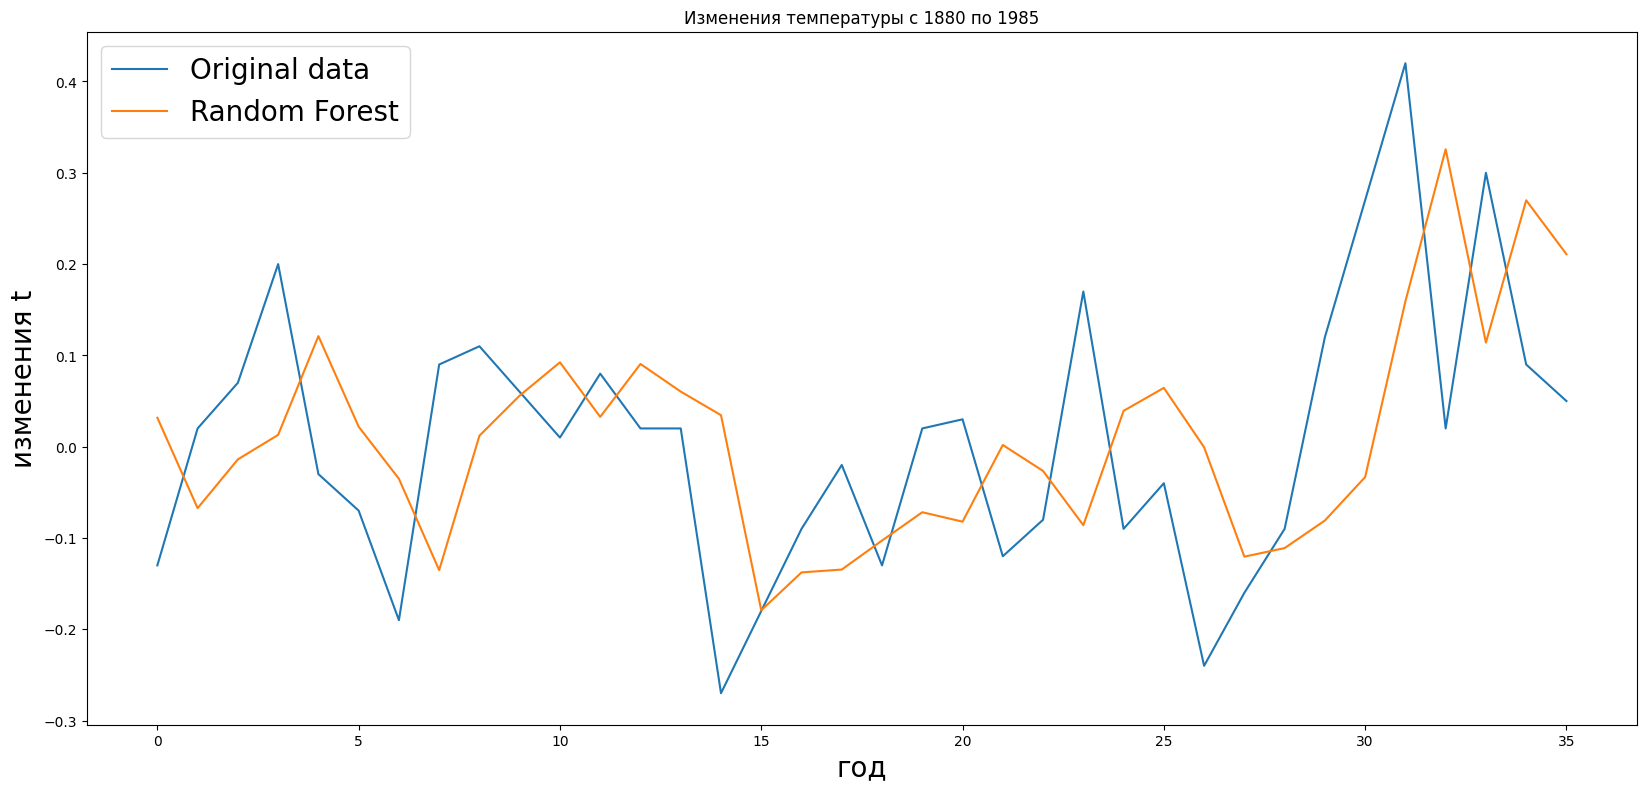

In [12]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Изменения температуры с 1880 по 1985')
plt.ylabel('изменения t', fontsize="20")
plt.xlabel('год', fontsize="20")
plt.show()

In [13]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

In [14]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 0.21165354290023644
MAPE: 3.361384789356066
MAE: 0.17972222222222223
R2:  -1.0649167733674774


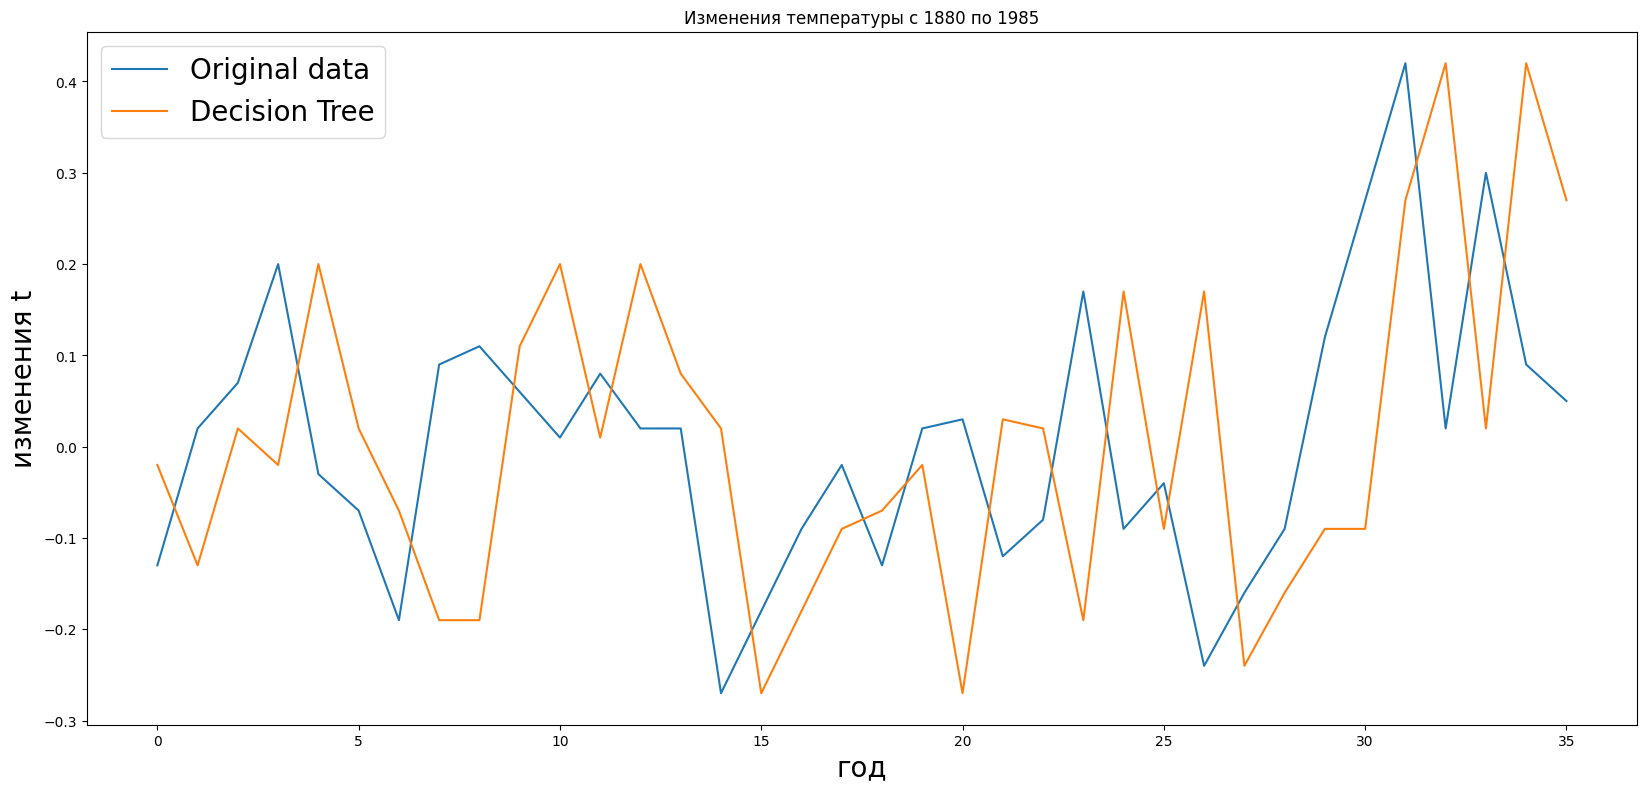

In [15]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Изменения температуры с 1880 по 1985')
plt.ylabel('изменения t', fontsize="20")
plt.xlabel('год', fontsize="20")
plt.show()

Детекция аномалий с помощью изолированного дерева

In [16]:
from sklearn.ensemble import IsolationForest

In [17]:
df = pd.read_csv('data/Annual changes in global temperature 18801985.csv')
df.set_index('x').sort_index()
df

,Unnamed: 0,x
0,1,-0.40
1,2,-0.37
2,3,-0.43
3,4,-0.47
4,5,-0.72
...,...,...
101,102,0.42
102,103,0.02
103,104,0.30
104,105,0.09


In [18]:
model = IsolationForest(contamination=0.004)
model.fit(df[['x']])

IsolationForest(contamination=0.004)

In [19]:
df['outliers'] = pd.Series(model.predict(df[['x']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [20]:
df.query('outliers=="yes"')

,Unnamed: 0,x,outliers
4,5,-0.72,yes


In [22]:
fig = px.scatter(df.reset_index(), y='x', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()